In [2]:
import numpy as np
from cmeutils.sampling import is_equilibrated, equil_sample
from cmeutils.dynamics import msd_from_gsd
import unyt as u
from unyt import Unit
import signac
import gsd.hoomd
import matplotlib.pyplot as plt
import os

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.
****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



In [3]:
project = signac.get_project("../validation/")

520


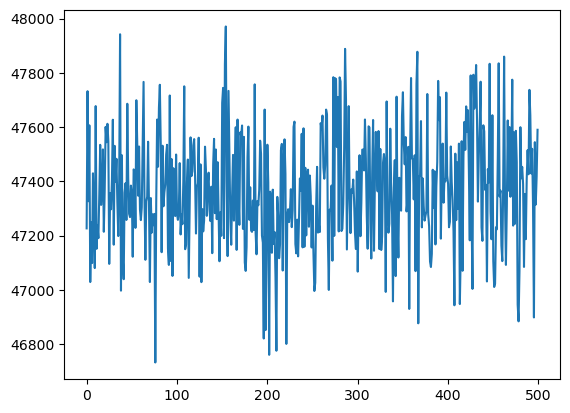

In [24]:
for job in project.find_jobs({"doc.volume_sampled": True}):
    if job.doc.nvt_runs < 1:
        continue
    if job.sp.kT != 1.8:
        continue
    data = np.genfromtxt(job.fn("log-nvt0.txt"), names=True)
    pe = data["mdcomputeThermodynamicQuantitiespotential_energy"]
    pressure = data["mdcomputeThermodynamicQuantitiespressure"]
    temp = data["mdcomputeThermodynamicQuantitieskinetic_temperature"]
    plt.plot(pe[-500:])
    with gsd.hoomd.open(job.fn("trajectory-nvt0.gsd")) as traj:
        print(len(traj))

# Check for NVT equilibration:

In [16]:
for job in project.find_jobs(filter={"doc.nvt_equilibrated": False, "doc.volume_sampled": True}):
    if job.doc.nvt_runs < 1:
        continue
    fpath = job.fn(f"log-npt{job.doc.nvt_runs-1}.txt")
    data = np.genfromtxt(fpath, names=True)
    pe = data["mdcomputeThermodynamicQuantitiespotential_energy"]
    sample_idx = 500
    pe_eq = is_equilibrated(pe[sample_idx:], threshold_fraction=0.20, threshold_neff=200)[0]
    if pe_eq is True:
        print("equilibrated")
        print(job)
        job.doc.nvt_equilibrated = True
    else:
        print("not equilibrated")
        print(job, job.sp.kT)
        job.doc.nvt_equilibrated = False
        
    print()

not equilibrated
e6e236135ac867add24f9d4d31ee2741 1.8



In [29]:
for job in project.find_jobs(filter={"doc.nvt_equilibrated": True, "doc.msd_sampled": False}):
    print(job.sp.kT)


3.8
3.6
1.0
1.6
1.2
2.0
1.4
3.8
1.0
1.2
2.6


# Calculate MSD:

/home/chrisjones4/miniconda3/envs/jankflow/lib/python3.9/site-packages/synced_collections/numpy_utils.py:46: NumpyConversionWarning: Any numpy types provided will be transparently converted to the closest base Python equivalents.
  warnings.warn(NUMPY_CONVERSION_WARNING, NumpyConversionWarning)


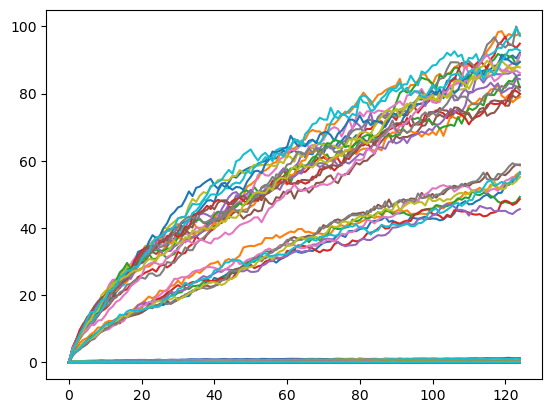

In [4]:
chunk_size = 125
start_frame = 20
end_frame = 500 - chunk_size
n_samples = 10

for job in project.find_jobs(filter={"doc.nvt_equilibrated": True, "doc.msd_sampled": False}):
    fpath = job.fn(f"trajectory-nvt{job.doc.nvt_runs-1}.gsd")
    with gsd.hoomd.open(fpath) as traj:
        end_frame = len(traj) - chunk_size
        random_starts = np.random.randint(start_frame, end_frame, n_samples)
        
    window_slopes = []
    steps_per_frame = job.sp.gsd_write_freq
    ts = job.doc.real_time_step * 1e-15
    ts_frame = steps_per_frame * ts
    
    for i in random_starts:
        msd = msd_from_gsd(
            gsdfile=fpath,
            start=int(i),
            stop=int(i) + chunk_size,
            atom_types="all",
            msd_mode="direct"
        )
        
        msd_data = np.copy(msd.msd)
        msd_data *= job.doc.ref_length**2 * 1e-18
        time = np.arange(0, chunk_size, 1) * ts_frame
        mid_chunk = msd_data[len(msd_data)//4:-len(msd_data)//4]
        mid_chunk_time = time[len(time)//4:-len(time)//4]
        window_slopes.append((mid_chunk[-1] - mid_chunk[0])/(mid_chunk_time[-1] - mid_chunk_time[0]))
        plt.plot(msd.msd)
    job.doc.D = np.mean(window_slopes)
    job.doc.D_std = np.std(window_slopes)

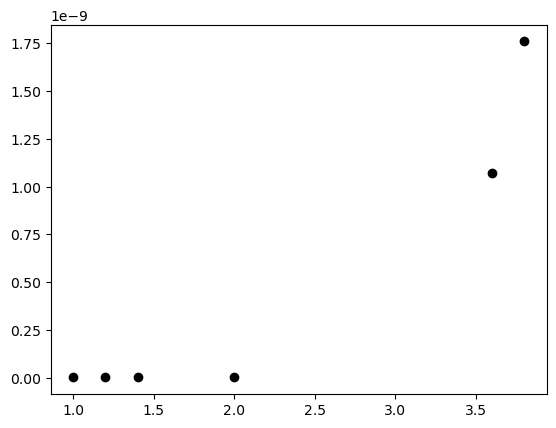

In [6]:
for job in project.find_jobs(filter={"doc.nvt_equilibrated": True, "doc.msd_sampled": False, "sigma_scale": 1.0}):
    plt.plot(job.sp.kT, job.doc.D, "ko")


In [25]:
job.sp

{'num_mols': 50, 'lengths': 25, 'density': 1.35, 'remove_hydrogens': True, 'remove_charges': False, 'sigma_scale': 1.0, 'kT': 2.2, 'pressure': None, 'n_steps': 50000000.0, 'shrink_kT': 6.0, 'shrink_n_steps': 10000000.0, 'shrink_period': 10000, 'r_cut': 2.5, 'tau_kT': 100, 'tau_pressure': 800, 'gamma': 0, 'gsd_write_freq': 100000.0, 'log_write_freq': 10000.0, 'sim_seed': 42}

In [26]:
job.doc

{'volume_sampled': True, 'msd_sampled': False, 'npt_equilibrated': True, 'nvt_equilibrated': False, 'npt_runs': 2, 'nvt_runs': 0, 'ref_mass': 32.06, 'ref_mass_units': 'amu', 'ref_energy': 1.7782, 'ref_energy_units': 'kJ/mol', 'ref_length': 0.36, 'ref_length_units': 'nm', 'pressure': 0.0015996, 'dt': 0.0003, 'tau_kT': 0.03, 'tau_pressure': 0.24, 'real_time_step': 0.4585801072525307, 'real_time_units': 'fs', 'avg_vol': 1.8952689036173838e-19, 'vol_std': 8.247219844022486e-22, 'mass_g': 2.246680898119277e-19, 'avg_density': 1.1854153750062457, 'density_std': 272.41675869082746}

In [5]:
for job in project:
    print(job.doc.ref_length)

0.3438
0.3438
0.3438
0.3438
0.3438
0.3438
0.3438
0.3438
0.3438
0.3438
0.3438
0.3438
0.3438
0.3438
0.36
0.36
0.36
0.36
0.36
0.36
0.36
0.36
0.36
0.36
0.36
0.36
0.36
0.36
0.3438
0.36
